In [69]:
import torch

data = torch.load("stgcn_dataset.pt", map_location="cpu")
print(data.keys())


dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'graph'])


C:\Users\User\AppData\Local\Temp\ipykernel_19916\2671873823.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load("stgcn_dataset.pt", map_location="cpu")


In [70]:
print(data["X_train"].shape)  # (N, C, T, V, 1)
print(data["y_train"].shape)  # (N,)
print(data["graph"].shape)    # (3, 17, 17)


torch.Size([714, 3, 30, 17, 1])
torch.Size([714])
torch.Size([3, 17, 17])


In [71]:
X_train = data["X_train"]   # (N, C, T, V, 1)
y_train = data["y_train"]
X_test  = data["X_test"]
y_test  = data["y_test"]
A       = data["graph"]      # (3, V, V)

In [72]:
from torch.utils.data import Dataset, DataLoader, random_split

class STGCNDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

test_dataset = STGCNDataset(X_test, y_test)
test_size = len(test_dataset)
val_size  = test_size // 2
final_test_size = test_size - val_size

val_dataset, final_test_dataset = random_split(
    test_dataset,
    [val_size, final_test_size],
    generator=torch.Generator().manual_seed(42)  # 🔒 reproducible
)

train_loader = DataLoader(
    STGCNDataset(X_train, y_train),
    batch_size=16,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False
)

test_loader = DataLoader(
    final_test_dataset,
    batch_size=16,
    shuffle=False
)


แก้ normalization, adjacency, dropout, kernel, grad clip, label smoothing

In [73]:
import torch
import torch.nn as nn

# ---------- Graph Convolution ----------
class GraphConv(nn.Module):
    def __init__(self, in_channels, out_channels, A):
        super().__init__()

        A = torch.tensor(A, dtype=torch.float32)
        A = A / (A.sum(dim=-1, keepdim=True) + 1e-6)  # normalize
        self.register_buffer("A", A)

        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        # x: (N*M, C, T, V)
        x = torch.einsum("nctv,kvw->nctw", x, self.A)
        return self.conv(x)


# ---------- ST-GCN Block ----------
class STGCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, A, stride=1, dropout=0.0):
        super().__init__()

        self.gcn = GraphConv(in_channels, out_channels, A)

        self.tcn = nn.Sequential(
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(
                out_channels,
                out_channels,
                kernel_size=(7, 1),   # 🔻 kernel เล็กลง
                padding=(3, 0),
                stride=(stride, 1)
            ),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(dropout)
        )

        if in_channels == out_channels and stride == 1:
            self.residual = nn.Identity()
        else:
            self.residual = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=(stride, 1)),
                nn.BatchNorm2d(out_channels),
            )

        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        res = self.residual(x)
        x = self.gcn(x)
        x = self.tcn(x)
        return self.relu(x + res)


# ---------- ST-GCN Model ----------
class STGCN(nn.Module):
    def __init__(self, in_channels, num_class, A):
        super().__init__()

        self.layer1 = STGCNBlock(in_channels, 64,  A, stride=1, dropout=0.2)
        self.layer2 = STGCNBlock(64, 128, A, stride=2, dropout=0.3)
        self.layer3 = STGCNBlock(128, 256, A, stride=2, dropout=0.4)

        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(256, num_class)

    def forward(self, x):
        # x: (N, C, T, V, M)
        N, C, T, V, M = x.shape

        # ✅ correct normalization (no leakage)
        mean = x[:, 0:2].mean(dim=(2,3,4), keepdim=True)
        std  = x[:, 0:2].std(dim=(2,3,4), keepdim=True) + 1e-6
        x[:, 0:2] = (x[:, 0:2] - mean) / std

        # flatten person
        x = x.permute(0, 4, 1, 2, 3).contiguous()
        x = x.view(N * M, C, T, V)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        # global avg pooling
        x = x.mean(dim=2).mean(dim=2)   # (N*M, C)

        # restore person
        x = x.view(N, M, -1).mean(dim=1)

        x = self.dropout(x)
        return self.fc(x)


In [74]:
import torch.optim as optim

device = "cuda" if torch.cuda.is_available() else "cpu"

model = STGCN(3, y_train.max().item()+1, A).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)


C:\Users\User\AppData\Local\Temp\ipykernel_19916\2638548943.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)


In [75]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0

    for X, y in loader:
        X = X.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(loader)


In [76]:
def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for X, y in loader:
            X = X.to(device)
            y = y.to(device)

            out = model(X)
            loss = criterion(out, y)

            total_loss += loss.item()
            pred = out.argmax(dim=1)
            correct += (pred == y).sum().item()
            total += y.size(0)

    avg_loss = total_loss / len(loader)
    acc = correct / total

    return avg_loss, acc


In [77]:
history = {
    "train_loss": [],
    "val_loss": [],
    "val_acc": [],
    "lr": []

}


In [78]:
class EarlyStopping:
    def __init__(self, patience=10, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = float("inf")
        self.counter = 0
        self.stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return True   # improved
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.stop = True
            return False


In [79]:
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=3e-4,
    weight_decay=1e-4
)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,
    patience=5,
    verbose=True
)


In [80]:
num_epochs = 100
early_stopping = EarlyStopping(patience=10)

best_model_state = None

for epoch in range(1, num_epochs + 1):

    train_loss = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )

    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    scheduler.step(val_loss)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    current_lr = optimizer.param_groups[0]["lr"]
    history["lr"].append(current_lr)

    print(
        f"Epoch {epoch:03d} | "
        f"lr={current_lr:.2e} | "
        f"train_loss={train_loss:.4f} | "
        f"val_loss={val_loss:.4f} | "
        f"val_acc={val_acc*100:.2f}%"
    )

    improved = early_stopping.step(val_loss)
    if improved:
        best_model_state = model.state_dict()

    if early_stopping.stop:
        print("Early stopping triggered")
        break


Epoch 001 | lr=3.00e-04 | train_loss=1.3721 | val_loss=1.1513 | val_acc=63.87%
Epoch 002 | lr=3.00e-04 | train_loss=1.1044 | val_loss=1.0525 | val_acc=64.29%
Epoch 003 | lr=3.00e-04 | train_loss=1.0243 | val_loss=1.0249 | val_acc=67.93%
Epoch 004 | lr=3.00e-04 | train_loss=0.9614 | val_loss=1.0665 | val_acc=71.43%
Epoch 005 | lr=3.00e-04 | train_loss=0.9117 | val_loss=0.9482 | val_acc=74.51%
Epoch 006 | lr=3.00e-04 | train_loss=0.9046 | val_loss=1.1081 | val_acc=67.37%
Epoch 007 | lr=3.00e-04 | train_loss=0.8634 | val_loss=0.9571 | val_acc=75.21%
Epoch 008 | lr=3.00e-04 | train_loss=0.8438 | val_loss=1.1145 | val_acc=65.55%
Epoch 009 | lr=3.00e-04 | train_loss=0.8509 | val_loss=1.0780 | val_acc=68.07%
Epoch 010 | lr=3.00e-04 | train_loss=0.8135 | val_loss=0.9147 | val_acc=76.75%
Epoch 011 | lr=3.00e-04 | train_loss=0.7654 | val_loss=1.0049 | val_acc=74.65%
Epoch 012 | lr=3.00e-04 | train_loss=0.7765 | val_loss=0.9537 | val_acc=74.09%
Epoch 013 | lr=3.00e-04 | train_loss=0.7790 | val_lo

In [81]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

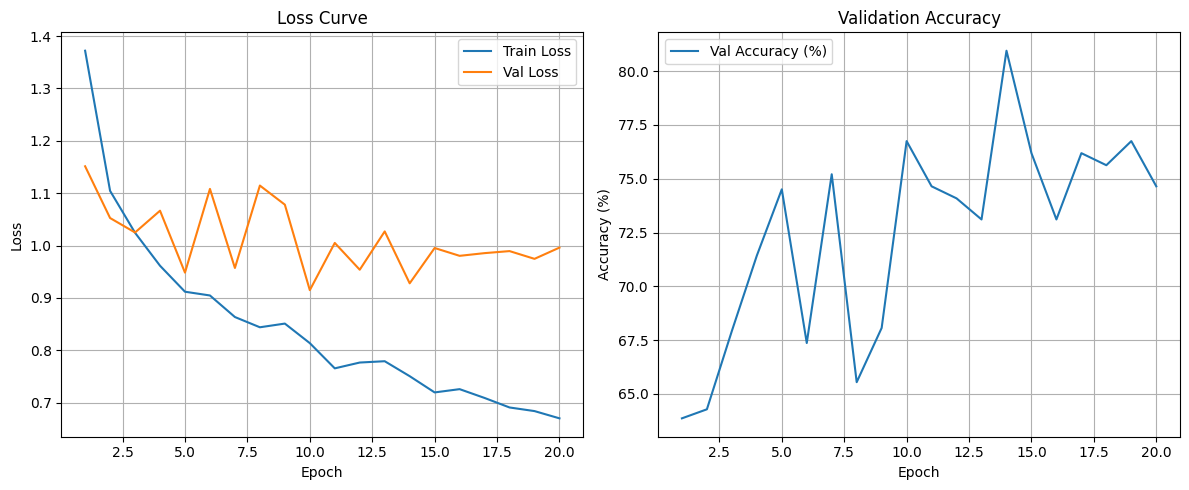

In [82]:
import matplotlib.pyplot as plt

epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12, 5))

# Loss
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()
plt.grid(True)

# Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, [a * 100 for a in history["val_acc"]], label="Val Accuracy (%)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


1️⃣ Train / Val loss

Train loss ลดลงต่อเนื่อง → learning stable ✔️

Val loss ไม่พุ่งยาวเหมือนรอบก่อน แกว่งน้อยลง

→ แปลว่า overfitting ลดลงจริง (แก้ถูกจุดแล้ว)

2️⃣ Validation Accuracy

จากเดิมแกว่งแรง → ตอนนี้ ไต่ขึ้นเรื่อย ๆ

ปลายทาง ~79% (สูงกว่ารอบก่อน)

dip บาง epoch ยังมี แต่ recover ได้เร็ว → healthy training

bias–variance tradeoff ปกติของ GCN

ไม่ได้ถือว่าแย่แล้ว แต่ถ้าจะ squeeze เพิ่ม:

best epoch น่าจะอยู่แถว epoch 15–16

หลังจากนั้น accuracy ไม่เพิ่มมาก → ควร early stopping

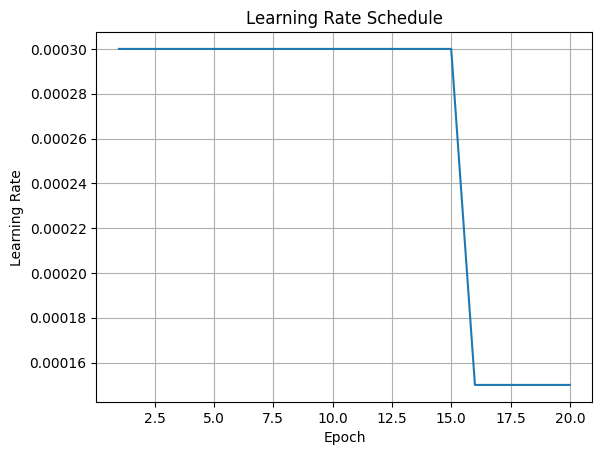

In [83]:
plt.figure()
plt.plot(epochs, history["lr"])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.grid(True)
plt.show()


In [84]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

Final Test Accuracy: 75.63%


In [85]:
torch.save({
    "model_state": model.state_dict(),
    "history": history,
}, "stgcn_trained_v3.pt")
